<a href="https://colab.research.google.com/github/ethantjones97/son_of_big_e/blob/master/numerai1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
%tensorflow_version 1.x
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print('tensorflow version: ' + tf.__version__)
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.models import Sequential
from keras.layers import Dense, Activation
import datetime
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
%load_ext tensorboard

tensorflow version: 1.15.0


Using TensorFlow backend.


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tytsp04x
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-tytsp04x
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=80410 sha256=b0b6b9b5457e52de6dd5443736fa444cb5438e2c86ff4a25503334835f06f15e
  Stored in directory: /tmp/pip-ephem-wheel-cache-nx2iq9g5/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:

import warnings
from time import process_time
import pandas as pd
import numpy as np
import seaborn as sns
import random
from xgboost import XGBRegressor
!pip install numerapi
import numerapi
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, preprocessing, utils, neighbors, ensemble)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [0]:
warnings.simplefilter(action='ignore', category=FutureWarning)

TOURNAMENT_NAME = 'kazutsugi'

TARGET_NAME = f'target_{TOURNAMENT_NAME}'
PREDICTION_NAME = f'prediction_{TOURNAMENT_NAME}'

BENCHMARK = 0
BAND = 0.2

In [0]:
print("# Loading data...")
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz").set_index("id")
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz").set_index("id")
feature_names = [f for f in training_data.columns if f.startswith("feature")]
training_data["erano"] = training_data.era.str.slice(3).astype(int)
eras = training_data.erano
print(f"Loaded {len(feature_names)} features" + "\n")
print("Training data shape: " + f"{training_data.shape}")
print("Tournament data shape: " + f"{tournament_data.shape}")
print("Eras summary: ")
eras.describe()

# Loading data...
Loaded 310 features

Training data shape: (501808, 314)
Tournament data shape: (1681205, 313)
Eras summary: 


count    501808.000000
mean         64.001987
std          33.332945
min           1.000000
25%          37.000000
50%          64.000000
75%          93.000000
max         120.000000
Name: erano, dtype: float64

In [0]:
training_data.head()

,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,...,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi,erano
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,0.25,...,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75,1
n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,0.50,...,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25,1
n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,0.50,...,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00,1
n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,0.50,...,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00,1
n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,0.25,...,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75,1


In [0]:
tournament_data.head()

,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,0.25,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,0.25,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,0.25,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


In [0]:
pd.DataFrame(data=training_data['era'])

,era
id,
n000315175b67977,era1
n0014af834a96cdd,era1
n001c93979ac41d4,era1
n0034e4143f22a13,era1
n00679d1a636062f,era1
...,...
nff6a8a8feaeeb52,era120
nff6af62a0996372,era120
nff9288983b8c040,era120


In [0]:
class big_e_bot():
    def __init__(self):
        self.training_data = training_data
        self.tournament_data = tournament_data
        self.feature_names = feature_names
        self.feature_groups = []
        self.nn_model = []
        self.nn_estimate1 = []
        self.prediction = []
        self.accuracy_score = []
        self.pearson_score = []
        self.example_batch = []
        self.example_result = []
        self.x_train = []
        self.x_test = []
        self.y_train = []
        self.y_test = []
    
    def comparison_plot(self, feature1, feature2, feature3, feature4):    
        sns.pairplot(self.training_data[[feature1, feature2, feature3, feature4]], diag_kind="kde")
    
    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.training_data[feature_names], 
                                                                                self.training_data[TARGET_NAME], 
                                                                                test_size=0.1)
        print('train features shape: ')
        print(self.X_train.shape)
        print('test features shape: ') 
        print(self.y_train.shape)
        print('train labels shape: ')
        print(self.X_test.shape)
        print('test labels shape: ')
        print(self.y_test.shape)

    def payout(scores):
        return ((scores - BENCHMARK)/BAND).clip(lower=-1, upper=1)

    def build_nn_model(self, mean_kernel=.5, std_kernel=.05, width1=5, width2=5):
        keras.initializers.RandomNormal(mean=mean_kernel, stddev=std_kernel, seed=None)
        self.nn_model = Sequential()
        self.nn_model.add(Dense(width1, input_dim=len(self.feature_names), activation='relu'))
        self.nn_model.add(Dense(width2, activation='relu'))
        self.nn_model.add(Dense(1, activation='sigmoid'))  # TODO: may not need activation
        self.nn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    
    def example_fit(self):
        self.example_batch = self.X_train[:10]
        self.example_result = self.nn_model.predict(self.example_batch)
        self.example_result
    
    def fit_nn_model(self, EPOCHS=500, BATCH_SIZE=500, VALIDATION_SPLIT = .2, callbacks=[tfdocs.modeling.EpochDots()]):
        self.nn_estimate1 = self.nn_model.fit(self.X_train, self.y_train, 
                                              epochs=EPOCHS, batch_size=BATCH_SIZE,
                                              validation_split = VALIDATION_SPLIT, verbose=0,
                                              callbacks=[tfdocs.modeling.EpochDots()])
    def predict_w_model(self):
        self.y_pred = self.nn_model.predict(self.X_test).flatten()
    
    def correlation_score(self):
        return np.corrcoef(self.y_test, self.y_pred)[0,1]

    def plot_results(self):
        a = plt.axes(aspect='equal')
        plt.scatter(self.y_test, self.y_pred)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')   
        lims = [0, 1]
        plt.xlim(lims)
        plt.ylim(lims)
        _ = plt.plot(lims, lims)
    def plot_error(self):
        error = self.y_pred - self.y_test
        plt.hist(error, bins = 25)
        plt.xlabel("Prediction Error")
        _ = plt.ylabel("Count")


In [0]:
submission1 = big_e_bot()

In [0]:
submission1.split_data()

train features shape: 
(451627, 310)
test features shape: 
(451627,)
train labels shape: 
(50181, 310)
test labels shape: 
(50181,)


In [0]:
submission1.build_nn_model(width1=1000,width2=1000)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor






In [0]:
submission1.nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              311000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 1,313,001
Trainable params: 1,313,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
submission1.example_fit()

In [0]:
submission1.example_result

array([[0.47227743],
       [0.524523  ],
       [0.52392596],
       [0.5394891 ],
       [0.50086004],
       [0.4785971 ],
       [0.5429624 ],
       [0.5692883 ],
       [0.5359118 ],
       [0.5044794 ]], dtype=float32)

In [0]:
submission1.fit_nn_model(EPOCHS=250, BATCH_SIZE=10000)




Epoch: 0, loss:0.1365,  mean_absolute_error:0.3135,  mean_squared_error:0.1365,  val_loss:0.1248,  val_mean_absolute_error:0.3005,  val_mean_squared_error:0.1248,  
.........................

In [0]:
hist = pd.DataFrame(submission1.nn_estimate1.history)
hist['epoch'] = submission1.nn_estimate1.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
20,0.128182,0.307506,0.128182,0.119097,0.296506,0.119097,20
21,0.127698,0.307003,0.127698,0.118701,0.296012,0.118701,21
22,0.127160,0.306175,0.127160,0.118142,0.295271,0.118142,22
23,0.128908,0.308204,0.128908,0.117482,0.294453,0.117482,23
24,0.129332,0.308886,0.129332,0.116397,0.292956,0.116397,24


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

submission1.nn_estimate2 = submission1.fit_nn_model(EPOCHS=10, BATCH_SIZE=150, callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1247,  mean_absolute_error:0.3015,  mean_squared_error:0.1247,  val_loss:0.1247,  val_mean_absolute_error:0.3013,  val_mean_squared_error:0.1247,  
..........

In [0]:
submission1.predict_w_model()

In [0]:
submission1.y_pred

array([0.43869367, 0.5079428 , 0.5405092 , ..., 0.5080442 , 0.48046437,
       0.49350652], dtype=float32)

In [0]:
df_test = pd.DataFrame(data=submission1.y_test)

In [0]:
df_test['target_kazutsugi']

id
n59d85b3a1ddd601    1.00
ne5454df5a2a0e3f    0.25
nc380bf456b9278d    0.00
nd817e36ba0f9032    0.50
n81d4b203a518118    0.25
                    ... 
n7a27614f5b98740    1.00
n54b67b63753d6c7    1.00
n6f867bb35d23c8a    0.50
n78213c3e481043a    0.75
nb7882a5b65d3f94    0.75
Name: target_kazutsugi, Length: 50181, dtype: float64

In [0]:
df_pred = pd.DataFrame(data=submission1.y_pred, columns=['pred'], index=list(df_test.index))

In [0]:
df_pred['pred']

n59d85b3a1ddd601    0.438694
ne5454df5a2a0e3f    0.507943
nc380bf456b9278d    0.540509
nd817e36ba0f9032    0.568837
n81d4b203a518118    0.503642
                      ...   
n7a27614f5b98740    0.529556
n54b67b63753d6c7    0.419484
n6f867bb35d23c8a    0.508044
n78213c3e481043a    0.480464
nb7882a5b65d3f94    0.493507
Name: pred, Length: 50181, dtype: float32

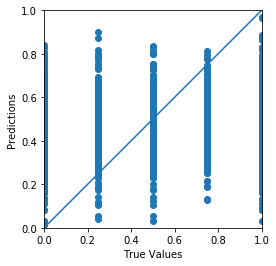

In [0]:
submission1.plot_results()

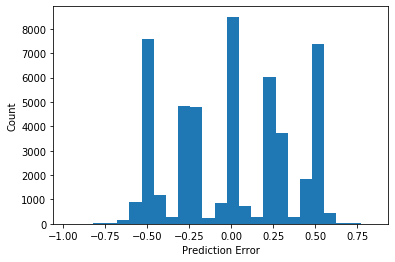

In [0]:
submission1.plot_error()

In [0]:
df_pred.index.name = 'id'
df_pred.columns = ['prediction_kazutsugi']
df_pred.head()

,prediction_kazutsugi
id,
n59d85b3a1ddd601,0.438694
ne5454df5a2a0e3f,0.507943
nc380bf456b9278d,0.540509
nd817e36ba0f9032,0.568837
n81d4b203a518118,0.503642


In [0]:
df_pred.to_csv("predictions.csv", index=True)